# Part I - docker compose

Part I is about using docker compose to start multiple docker containers. Using docker compose you can also put all commands you normally need to run a container in a file. It can be submitted to version control system.

In [ ]:
import os
print(os.listdir())

In [ ]:
!tree

#### Already done

In notebook xyz a Dockerfile and requirements were created. These are repeated such that this directory is self contained. This is stored in the `docker` directory.

In [ ]:
print(os.listdir('docker'))

In [ ]:
%%writefile ./docker/Dockerfile
FROM python:3.10.12-slim

# create app directory and move in the directory
WORKDIR app

# copy the requirements.txt in the app directory in the container
COPY ./requirements.txt .

# install and upgrade pip
RUN pip3 install --upgrade pip

# install the dependencies in the requirement.txt
RUN pip3 install -r requirements.txt

# expose all these port
EXPOSE 8786 8787 30000-65535

# execute `dask scheduler --host 0.0.0.0` in container when 
# we run the container
CMD ["dask", "scheduler", "--host", "0.0.0.0"]
#CMD ["dask", "scheduler"]

Below we give the requirements.txt that contains all the dependencies we need for running our code

In [ ]:
%%writefile ./docker/requirements.txt
pandas==2.2.3
numpy==2.1.0
dask[complete]==2024.9.1
dask-cloudprovider==2024.9.0
s3fs==2024.9.0
dask-expr==1.1.15
awscli
jupyter


In [ ]:
os.listdir('docker')

Below we use docker compose to create a two services. Here we `build` the image two times. Once the image is build for the first time it will build very quickly afterwards since all layers are cached. You can also refer to an image (that would be neater)

**remark** - please note that in order to create a daskworker we override the start command from the Dockerfile using `command`. Containers in a docker compose stack share the same network and call each other using the service name. Docker will resolve the DNS to an internal IP.

In [ ]:
%%writefile docker-compose.yml
services:
  dask-scheduler:
    restart: always
    #context: ./
    build: ./docker/
    container_name: dask-scheduler-container
    ports:
      - 8786-8787:8786-8787
  dask-worker:
    restart: always
    #context: ./
    build: ./docker
    #container_name: dask-worker-1
    command: "dask worker tcp://dask-scheduler:8786"
    deploy:
      mode: replicated
      replicas: 2

we can first build the images that our dockerfile is referencing.

In [ ]:
!docker compose build

now there will be two images related to this docker compose deployment. These will have the current container name plus the service name.

In [ ]:
#!docker images

now we can start the services

In [ ]:
!docker-compose up -d

In [ ]:
!docker ps

In [ ]:
!docker logs dask-scheduler-container

In [ ]:
!docker logs deploy-dask-cluster-docker-compose-dask-worker-1

In [ ]:
!docker logs deploy-dask-cluster-docker-compose-dask-worker-2

In [ ]:
from dask.distributed import Client

In [ ]:
client = Client(address="tcp://localhost:8786")

In [ ]:
client

click the dashboard link  `http://localhost:8787/status` to see the dashboard

docker compose created an internal bridge network. The internal IP from the scheduler above can be found in the docker network that was created.

In [ ]:
!docker network ls

inspect the network to see the internal IP adresses and compare to above

In [ ]:
import dask.array as da

xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000))
yd = xd.mean(axis=0)
yd.compute()

In [ ]:
#!docker network inspect deploy-dask-cluster-docker-compose_default

clean up the resources

In [ ]:
client.close()

In [ ]:
!docker compose down

# Part II - Kubernetes

Allows deployment of different containers on different computers. The steps taken are from docker course. in kubernetes the smalles unit is a pod a pod can contain one or more containers. The computers in the cluster are called nodes. The communication between nodes is arranged by a master node (control pane). There are basically two steps for working with kubernetes: 1) creation of the cluster (e.g. using eksclt) and 2) kubectl to connect and manage deployments on the cluster remotely.

other links (to check):

https://www.youtube.com/watch?v=p6xDCz00TxU

https://www.dabbleofdevops.com/blog/deploy-and-scale-your-dask-cluster-with-kubernetes

Let's push the `dask-cluster-image` to docker hub. First tag the image with my dockerhub username.

In [ ]:
!docker tag dask-cluster-image longtong/dask-cluster-image

In [ ]:
!docker push longtong/dask-cluster-image

## 1.1 kubernetes basics

start a k8s minikube cluster using 

In [ ]:
!minikube start

**remark** - I get a lot of warnings. I seems to work though but not always with the commands from course.

on windows. After this check the status of the cluster by enterin

In [ ]:
!minikube status

In [ ]:
!minikube ip

to get the ip of the cluster. In order to login into the container I had to use 

`minikube ssh`

which is different from the course.

To get info on the cluster type

In [ ]:
!kubectl cluster-info

to get the nodes

In [ ]:
!kubectl get nodes

In [ ]:
!kubectl get pods --namespace=kub-system

The `namespace` argument is not mandatory

In [ ]:
!kubectl get namespaces

#### Create a pod

In [ ]:
!kubectl run dask --image=longtong/dask-cluster-image

to get information on the pod type

In [ ]:
!kubectl describe pod dask

The pod runs inside the cluster but is not available outside of the cluster. It only has an internal IP adress. To connect outside of the cluster **services** are needed. 

You can log into the cluster (see above) and check containers `docker ps | grep dask` and look at the container logs (or exec into them).

In [ ]:
!kubectl get pods -o wide

delete the pod

In [ ]:
!kubectl delete pod dask

#### Create deployment

To create multiple pods and manage configuraton (scale) the best way to do this is with deployments. (use git bash and use `alias k='kubectl'`

In [ ]:
!kubectl create deployment dask --image=longtong/dask-cluster-image

get the deployments

In [ ]:
!kubectl get deploy

describe deployment

In [ ]:
!kubectl describe deployment dask

ReplicaSet manages all pods in your deployment. 

To increase the a higher number of pods

In [ ]:
!kubectl scale deployment dask --replicas=3

In [ ]:
!kubectl get pods -o wide

#### Services

Services are required if you want to connect to deployment via specific IP adresses. There different types services. ClusterIP is single IP adress for single deployment. It is also possible to export port such that pods can be reached from outside the cluster.

to expose a deployment (e.g. database) to other deployments inside the cluster (**not external**) use: 

In [ ]:
!kubectl expose deployment dask --port=8787 --target-port=8787

where `port` refers to the port on the local machine and `target-port` refers to the port inside the containder. To see the services type

`k get services` or

In [ ]:
!kubectl get svc

get details about the service

In [ ]:
!kubectl describe service dask

delete this service

In [ ]:
!kubectl delete svc dask

create a different type of deployment

In [ ]:
!kubectl expose deployment dask --type=NodePort --port=8786 --port=8787

In [ ]:
!kubectl get svc

after this command the service can be accessed (not in my pc) via te `<minikube ip>:32225` via the webbrowser. On my machine only he following command works

`minikube service dask`

now create a LoadBalancer service

`k expose deployment dask --type=LoadBalancer --port=3000`


you can expose more ports in a service. I am able to connect using `minikube service dask` it seems to have issues and give alternative ports.

In [ ]:
from dask.distributed import Client

In [ ]:
client = Client(address='tcp://127.0.0.1:58843')
client

In [ ]:
client.close()

#### StrategyType

Change the image used in the deployment

In [ ]:
!kubectl set image deployment dask dask-cluster-image=longtong/k8s-web-hello:2.0.0

the argument `dask-cluster-image=longtong/k8s-web-hello:2.0.0` tell k8s to replace the image used for the deployment  by a new one.

In [ ]:
!kubectl rollout status deploy dask

In [ ]:
!kubectl get pods

In [ ]:
!kubectl get svc

clean up resources

In [89]:
!kubectl delete all --all

pod "dask-scheduler-f94b8654d-dn468" deleted
pod "dask-worker-c6cdff5f6-69rxd" deleted
pod "dask-worker-c6cdff5f6-fslct" deleted
pod "dask-worker-c6cdff5f6-w22tv" deleted
service "dask-scheduler" deleted
service "kubernetes" deleted
deployment.apps "dask-scheduler" deleted
deployment.apps "dask-worker" deleted


In [90]:
!kubectl get deploy
!kubectl get svc
!kubectl get pods

No resources found in default namespace.


NAME         TYPE        CLUSTER-IP   EXTERNAL-IP   PORT(S)   AGE
kubernetes   ClusterIP   10.96.0.1    <none>        443/TCP   17s
NAME                             READY   STATUS        RESTARTS   AGE
dask-scheduler-f94b8654d-cv59x   0/1     Completed     0          19s
dask-worker-c6cdff5f6-6vq86      0/1     Error         0          19s
dask-worker-c6cdff5f6-8b965      0/1     Terminating   0          19s
dask-worker-c6cdff5f6-nm76m      0/1     Terminating   0          19s


### 1.2 Deployments using yaml files

More information on different fields of the yaml files can be found here:
- https://kubernetes.io/docs/reference/kubernetes-api/



#### ChatGPT

In [91]:
%%writefile dask-scheduler-deployment.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: dask-scheduler
spec:
  replicas: 1
  selector:
    matchLabels:
      app: dask-scheduler
  template:
    metadata:
      labels:
        app: dask-scheduler
    spec:
      containers:
      - name: dask-scheduler
        image: longtong/dask-cluster-image #daskdev/dask:latest
        args: ["dask-scheduler"]
        ports:
        - containerPort: 8786
        - containerPort: 8787
---
apiVersion: v1
kind: Service
metadata:
  name: dask-scheduler
spec:
  type: NodePort
  selector:
    app: dask-scheduler
  ports:
  - name: scheduler
    port: 8786
    targetPort: 8786
    nodePort: 31876  # Within 30000-65535 range
  - name: dashboard
    port: 8787
    targetPort: 8787
    nodePort: 31877  # Within 30000-65535 range

Overwriting dask-scheduler-deployment.yaml


In [92]:
!kubectl apply -f dask-scheduler-deployment.yaml

deployment.apps/dask-scheduler created
service/dask-scheduler created


In [94]:
!kubectl get deploy
!kubectl get pods -o wide
!kubectl get svc

NAME             READY   UP-TO-DATE   AVAILABLE   AGE
dask-scheduler   1/1     1            1           6s
NAME                             READY   STATUS    RESTARTS   AGE   IP            NODE       NOMINATED NODE   READINESS GATES
dask-scheduler-f94b8654d-k5lxj   1/1     Running   0          6s    10.244.0.34   minikube   <none>           <none>
NAME             TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)                         AGE
dask-scheduler   NodePort    10.110.219.124   <none>        8786:31876/TCP,8787:31877/TCP   7s
kubernetes       ClusterIP   10.96.0.1        <none>        443/TCP                         83s


In [95]:
%%writefile dask-worker-deployment.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: dask-worker
spec:
  replicas: 3  # Number of workers
  selector:
    matchLabels:
      app: dask-worker
  template:
    metadata:
      labels:
        app: dask-worker
    spec:
      containers:
      - name: dask-worker
        image: longtong/dask-cluster-image #daskdev/dask:latest
        args: ["dask-worker", "dask-scheduler.default.svc.cluster.local:8786"]
        #env:
        #- name: DASK_DISTRIBUTED__COMM__DEFAULT_PORT
        #  value: "30000"  # Set the minimum port range for worker communications
        #- name: DASK_DISTRIBUTED__COMM__RETRY_PORTS
        #  value: "30000:65535"  # Set the range for communication retries

Overwriting dask-worker-deployment.yaml


In [98]:
!kubectl apply -f dask-worker-deployment.yaml

deployment.apps/dask-worker unchanged


In [99]:
!kubectl get deploy
!kubectl get pods -o wide
!kubectl get svc

NAME             READY   UP-TO-DATE   AVAILABLE   AGE
dask-scheduler   1/1     1            1           83s
dask-worker      3/3     3            3           54s
NAME                             READY   STATUS    RESTARTS   AGE   IP            NODE       NOMINATED NODE   READINESS GATES
dask-scheduler-f94b8654d-k5lxj   1/1     Running   0          84s   10.244.0.34   minikube   <none>           <none>
dask-worker-654888cbb9-8vjdm     1/1     Running   0          55s   10.244.0.36   minikube   <none>           <none>
dask-worker-654888cbb9-ncwxj     1/1     Running   0          55s   10.244.0.37   minikube   <none>           <none>
dask-worker-654888cbb9-qr7nd     1/1     Running   0          55s   10.244.0.35   minikube   <none>           <none>
NAME             TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)                         AGE
dask-scheduler   NodePort    10.110.219.124   <none>        8786:31876/TCP,8787:31877/TCP   84s
kubernetes       ClusterIP   10.96.0.1        <none>

run 

`minikube service dask-scheduler`

to get the scheduler ports. Use these in the connection below. Make sure you change http to tcp and link use the one linked to port 8786.

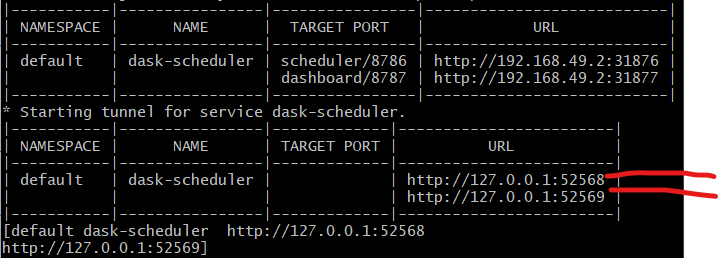

In [100]:
from dask.distributed import Client
client = Client(address='tcp://127.0.0.1:52620')
client

<Client: 'tcp://10.244.0.34:8786' processes=3 threads=36, memory=46.61 GiB>

2024-11-06 17:21:30,309 - distributed.client - ERROR - 
Traceback (most recent call last):
  File "C:\Users\sacha\anaconda3\envs\dask-cluster\lib\site-packages\distributed\utils.py", line 806, in wrapper
    return await func(*args, **kwargs)
  File "C:\Users\sacha\anaconda3\envs\dask-cluster\lib\site-packages\distributed\client.py", line 1543, in _reconnect
    await self._ensure_connected(timeout=timeout)
  File "C:\Users\sacha\anaconda3\envs\dask-cluster\lib\site-packages\distributed\client.py", line 1573, in _ensure_connected
    comm = await connect(
  File "C:\Users\sacha\anaconda3\envs\dask-cluster\lib\site-packages\distributed\comm\core.py", line 377, in connect
    handshake = await comm.read()
  File "C:\Users\sacha\anaconda3\envs\dask-cluster\lib\site-packages\distributed\comm\tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError


In [103]:
import dask.array as da

xd = da.random.normal(10, 0.1, size=(10_000, 10_000), chunks=(3000, 3000))
yd = xd.mean(axis=0)
yd

dask.array<mean_agg-aggregate, shape=(10000,), dtype=float64, chunksize=(3000,), chunktype=numpy.ndarray>

In [104]:
%%time
yd.compute()

CPU times: total: 0 ns
Wall time: 3.26 s


array([10.00167308, 10.00008504, 10.00178389, ..., 10.00121354,
        9.99846557,  9.99918733])

Let's use a simple dataset I found on the internet

In [105]:
!aws s3 ls s3://dlai-practical-data-science/data/raw/

2021-04-30 04:21:06    8457214 womens_clothing_ecommerce_reviews.csv


In [106]:
import dask.dataframe as dd
ddf = dd.read_csv('s3://dlai-practical-data-science/data/raw/*.csv', index_col=False, storage_options={'anon': True})
ddf

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
npartitions=1,,,,,,,,,,,
,int64,int64,int64,string,string,int64,int64,int64,string,string,string
,...,...,...,...,...,...,...,...,...,...,...


In [107]:
%%time
len(ddf)

CPU times: total: 0 ns
Wall time: 3.44 s


23486

In [108]:
%%time
ddf = ddf.dropna(how="all", subset="Class Name")
len(ddf)

CPU times: total: 0 ns
Wall time: 2.62 s


23472

In [109]:
%%time
ddf.groupby(by="Rating")["Rating"].count().compute()

CPU times: total: 15.6 ms
Wall time: 3.89 s


Rating
1      842
2     1565
3     2871
4     5077
5    13117
Name: Rating, dtype: int64

get mean rating per class name for classes with more than 100 reviews. This means we first need to determine which classes have more than 100 reviews.

In [113]:
# remove rows with NA in class name
ddf = ddf.dropna(how="all", subset="Class Name")

# counts per class name
counts_per_class_name = ddf["Class Name"].value_counts(dropna=False)

# create ddf_clean with only classes that have more than 100 counts
more_100_counts = counts_per_class_name > 100
more_100_indices = more_100_counts[more_100_counts].index
ddf_clean = ddf[ddf["Class Name"].isin(more_100_indices)]

# groupby class name and calculate mean rating
grouped = ddf_clean.groupby("Class Name")
mean_rating_per_class = grouped["Rating"].mean()

In [114]:
%%time
mean_rating_per_class.compute()

CPU times: total: 109 ms
Wall time: 9.13 s


Class Name
Blouses       4.154020
Dresses       4.150815
Fine gauge    4.260909
Intimates     4.279221
Jackets       4.295455
Jeans         4.360942
Knits         4.161677
Layering      4.376712
Legwear       4.278788
Lounge        4.301013
Outerwear     4.198171
Pants         4.265850
Shorts        4.255521
Skirts        4.245503
Sleep         4.285088
Sweaters      4.179272
Swim          4.197143
Trend         3.815126
Name: Rating, dtype: float64

In [117]:
ddf = dd.read_parquet(
    "s3://coiled-datasets/timeseries/20-years/parquet",
    storage_options={"anon": True, "use_ssl": True}
)

In [118]:
%%time
len(ddf)

CPU times: total: 62.5 ms
Wall time: 19.8 s


662256000

#### clean up resources

In [119]:
!kubectl delete all --all

pod "dask-scheduler-f94b8654d-k5lxj" deleted
pod "dask-worker-654888cbb9-8vjdm" deleted
pod "dask-worker-654888cbb9-ncwxj" deleted
pod "dask-worker-654888cbb9-qr7nd" deleted
service "dask-scheduler" deleted
service "kubernetes" deleted
deployment.apps "dask-scheduler" deleted
deployment.apps "dask-worker" deleted


In [120]:
!kubectl get deploy
!kubectl get svc
!kubectl get pods

No resources found in default namespace.


NAME         TYPE        CLUSTER-IP   EXTERNAL-IP   PORT(S)   AGE
kubernetes   ClusterIP   10.96.0.1    <none>        443/TCP   23s
NAME                             READY   STATUS        RESTARTS   AGE
dask-scheduler-f94b8654d-8xgg6   1/1     Terminating   0          24s
dask-worker-654888cbb9-hj2f5     1/1     Terminating   0          24s


In [121]:
client.close()